# Build an xarray.Dataset from Scratch

In this `How-To` we'll go through the process of building up an xarray.Dataset that could be used as an input to `Pipeline.calculate`. We'll generate random compositions and fake data to go along with these compositions. 


The dataset generated in this notebook is the basis for the `Building Pipelines` tutorial.

## First Steps

To begin, let's import the necessary libraries for this document and then make an empty :py:class:`xarray.Dataset`

In [1]:
import numpy as np
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.Dataset()
ds

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

### Compositions

Next, we generate random 'compositions' that we'll do simulated/virtual measurements at. We'll generate the compositions for a 2-dimensional space with components "A" and "B" as placeholders. You could imagine that A and B are the concentrations of two different preservatives in a liquid mixtures. 

In [2]:
num_measurements = 100
A = np.random.uniform(0,10,size=num_measurements)
B = np.random.uniform(0,25,size=num_measurements)
compositions = np.array([A,B]).T
compositions

array([[6.04158474e-01, 1.35801148e+01],
       [4.57246963e+00, 1.41058325e+00],
       [5.16633020e+00, 8.35310619e+00],
       [1.01856491e+00, 4.27628776e+00],
       [9.63679075e+00, 5.53740512e+00],
       [2.57838855e+00, 5.10618188e-01],
       [6.79354202e+00, 2.21223774e+01],
       [7.38336981e+00, 2.24474698e+01],
       [5.80667944e+00, 1.49342593e+00],
       [8.97651646e+00, 2.23791573e+01],
       [4.66669926e+00, 7.45513951e+00],
       [9.49494258e+00, 5.60275926e+00],
       [3.30764936e+00, 3.72256628e+00],
       [4.84420983e+00, 2.01478658e+01],
       [9.78984439e+00, 5.82417987e+00],
       [5.37105710e+00, 1.85955699e+01],
       [6.06256220e+00, 1.57074209e+00],
       [8.71348053e+00, 2.14228382e+01],
       [8.26136294e+00, 1.93178405e+01],
       [7.56380223e+00, 2.13813571e+01],
       [2.48179044e+00, 2.27665900e+01],
       [6.62591885e-02, 2.08618618e+01],
       [5.01933190e-01, 1.93937710e+01],
       [4.23581433e+00, 9.92020429e+00],
       [5.061690

Now let's add this information to the :py:class:`xarray.Dataset`. 

Note how, for the `composition` variable, we need to not only specify the name of the variable in the dataset but also the names of the dimensions of the data ('sample' and 'components').

In [3]:
ds['composition'] = (['sample','component'],compositions)
ds['component'] = ('component',['A','B'])
ds

<xarray.Dataset> Size: 2kB
Dimensions:      (sample: 100, component: 2)
Coordinates:
  * component    (component) <U1 8B 'A' 'B'
Dimensions without coordinates: sample
Data variables:
    composition  (sample, component) float64 2kB 0.6042 13.58 ... 1.641 3.759

Okay, in order to simulate a 'phase boundary' we'll create labels for the data. We'll draw an arbitrary line through the composition space and label the data that is above and below that line. 

Let's generate this data and add it to the dataset

In [4]:
labels = (A>(0.25*B-1)).astype(int)
ds['ground_truth_labels'] = ('sample',labels)
ds

<xarray.Dataset> Size: 2kB
Dimensions:              (sample: 100, component: 2)
Coordinates:
  * component            (component) <U1 8B 'A' 'B'
Dimensions without coordinates: sample
Data variables:
    composition          (sample, component) float64 2kB 5.7 1.36 ... 5.104
    ground_truth_labels  (sample) int64 800B 1 1 0 1 0 1 1 1 ... 1 1 1 1 1 0 1 1

Now we can plot the data. We do this using xarray by first extracting the compositions data variable into a new standalone xarray.Dataset and then calling plot.scatter on it. 

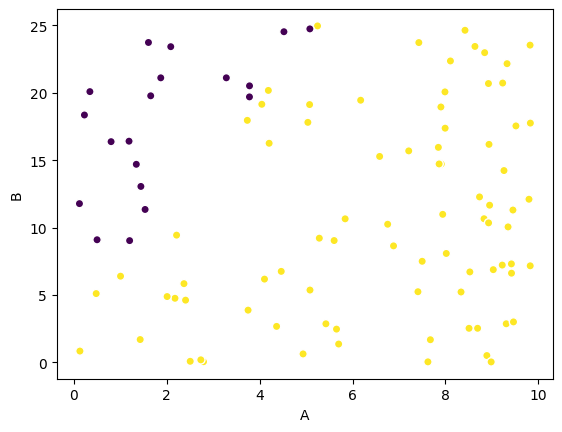

In [5]:
ds.composition.to_dataset('component').plot.scatter(x='A',y='B',c=ds.ground_truth_labels)

### Simulated Measurement Data

Now let's generate the 'measurement' data. We'll generate one measurement for each composition generated above. We'll generate two kinds of data that depend on the data label:

1. A flat background signal with random Gaussian noise
2. A power-law with a power of -4 that decays to a flat background

Both kinds of data will have random Gaussian noise.

In [6]:
#domain of the measurements (e.g., for scattering this would be q, for
#spectroscopy this would be wavelength or wavenumber)
x = np.geomspace(0.001,1.0,150)

measurements = []
for label in labels:
    if label==0:
        m = np.random.normal(loc=1.0, scale=0.25, size=x.shape[0])
        measurements.append(m)
    else:
        m = 1e-6*np.power(x,-4) + 1.0
        m += np.random.normal(loc=m, scale=0.25*m, size=x.shape[0])
        measurements.append(m)
        # measurements.append(1e-6*np.power(x,-4) + 1.0)


# Add the measurement data to the dataset
ds['measurement'] = (['sample','x'],measurements)
ds['x'] = ('x',x)
ds


<xarray.Dataset> Size: 124kB
Dimensions:              (sample: 100, component: 2, x: 150)
Coordinates:
  * component            (component) <U1 8B 'A' 'B'
  * x                    (x) float64 1kB 0.001 0.001047 0.001097 ... 0.9547 1.0
Dimensions without coordinates: sample
Data variables:
    composition          (sample, component) float64 2kB 5.7 1.36 ... 5.104
    ground_truth_labels  (sample) int64 800B 1 1 0 1 0 1 1 1 ... 1 1 1 1 1 0 1 1
    measurement          (sample, x) float64 120kB 1.915e+06 1.479e+06 ... 1.885

Now let's plot the two groups of data

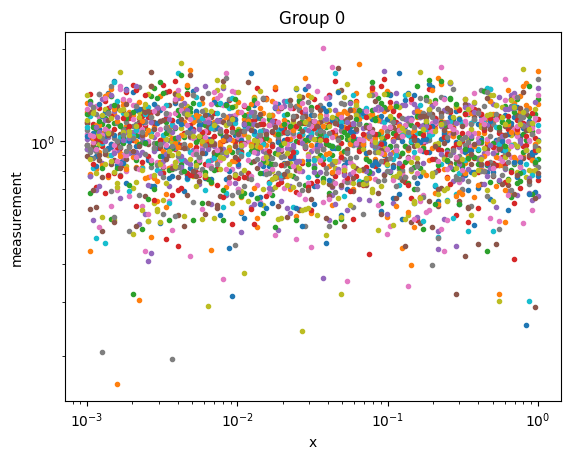

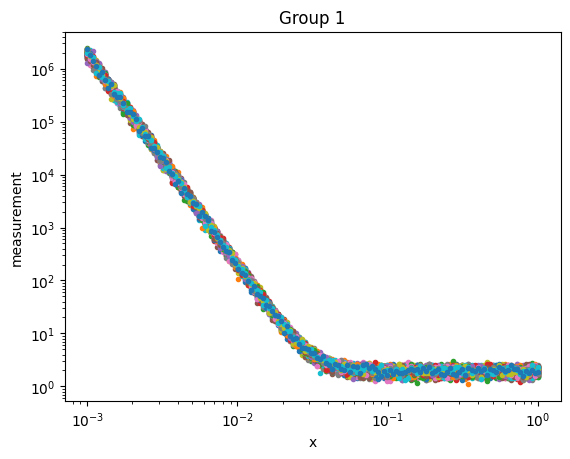

In [7]:
for label, sub_ds in ds.groupby('ground_truth_labels'):
    plt.figure()
    sub_ds.measurement.plot.line(x='x',marker='.',ls='None',xscale='log',yscale='log',add_legend=False)
    plt.title(f'Group {label}')

plt.show()


### Composition Grid

Okay, the final piece of data that you need to start is the composition grid. This grid defines the space that the agent will evaluate when choosing the next composition

In [10]:
num_grid_points = 50
A_grid = np.linspace(0,10,num_grid_points)
B_grid = np.linspace(0,25,num_grid_points)
composition_grid = np.meshgrid(A_grid,B_grid)
composition_grid = np.array([composition_grid[0].ravel(),composition_grid[1].ravel()]).T

ds['composition_grid'] = (['grid','component'],composition_grid)
ds

<xarray.Dataset> Size: 164kB
Dimensions:              (sample: 100, component: 2, x: 150, grid: 2500)
Coordinates:
  * component            (component) <U1 8B 'A' 'B'
  * x                    (x) float64 1kB 0.001 0.001047 0.001097 ... 0.9547 1.0
Dimensions without coordinates: sample, grid
Data variables:
    composition          (sample, component) float64 2kB 5.7 1.36 ... 5.104
    ground_truth_labels  (sample) int64 800B 1 1 0 1 0 1 1 1 ... 1 1 1 1 1 0 1 1
    measurement          (sample, x) float64 120kB 1.915e+06 1.479e+06 ... 1.885
    composition_grid     (grid, component) float64 40kB 0.0 0.0 ... 10.0 25.0

Let's inspect the grid in a plot

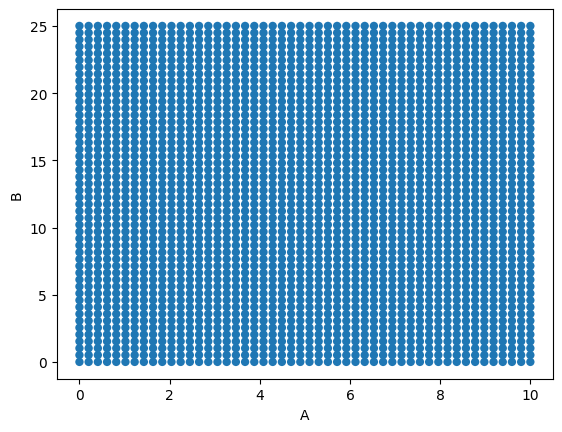

In [11]:
ds.composition_grid.to_dataset('component').plot.scatter(x='A',y='B',edgecolor='None')
plt.show()

## Saving the Dataset to disk

We can save this dataset to disk for use in other notebooks or to memorialize the input data used in a calculation. We'll use the `netcdf` format for this:

In [12]:

ds.to_netcdf('../data/example_dataset.nc')

## Conclusion

In this notebook, we demonstrated how to build an `xarray.Dataset` from scratch. 

We:

1. Created an empty dataset
2. Added composition data for samples
3. Added ground truth labels for the samples
4. Added simulated measurement data
5. Added a composition grid for the agent to explore
6. Saved the dataset to disk in netCDF format

The resulting dataset contains all the necessary components for training and evaluating an active learning agent:
- Sample compositions and their corresponding measurements
- Ground truth labels for validation
- A grid defining the composition space for exploration

This dataset structure represents a typical format expected by many agent pipelines in `AFL.double_agent`. The exact variables and variable names will change with the pipeline, but the concept of having measurement data and composition information that shares dimensions is a foundational feature of analyzing formulations and materials problems where the composition is varying. 